# How to train a new model on a new dataset from scratch in CoreNet

The purpose of this tutorial is to familiarize you with experimenting with new models and datasets from scratch in CoreNet. We implement a simple classification model on CIFAR10 dataset, then demonstrate how to launch the training and evaluation.

Let's first make sure our current working directory is the root folder of the repository.

In [1]:
import os

if os.getcwd().endswith("tutorials"):
    os.chdir("..")

assert os.path.exists(
    "corenet"
), f"We should be in the root repository folder, but we are in {os.getcwd()}"

! mkdir -p projects/playground_cifar10/classification

## Create new training configuration

Let's start by creating a YAML training configuration in the `projects/playground_cifar10` folder. You can find more training recipes in `projects/` folder. 

Note: The following jupyter notebook cells in this tutorial start with `%%file <path>`. This header instructs jupyter to write the content of the cell to the specified `<path>`, when executed. We leverage this feature to generate the YAML and Python files.

In [2]:
%%file projects/playground_cifar10/classification/cifar10.yaml

common:
    log_freq: 2000                 # Log the training metrics every 2000 iterations.

dataset:
    category: classification
    name: "cifar10"                # We'll register the "cifar10" name at DATASET_REGISTRY later in this tutorial.

    # The `corenet-train` entrypoint uses train_batch_size0 and val_batch_size0 values to construct 
    # training/validation batches during training. The `corenet-eval` entrypoint uses eval_batch_size0 to 
    # construct batches during evaluation (ie test).
    #
    # The effective batch size is: num_nodes x num_gpus x train_batch_size0
    train_batch_size0: 4
    val_batch_size0: 4
    eval_batch_size0: 1

    workers: 2
    persistent_workers: true
    pin_memory: true

model:
    classification:
        name: "two_layer"          # We'll register the "two_layer" name at MODEL_REGISTRY later in this tutorial.
        n_classes: 10

    layer:
        # Weight initialization parameters:
        conv_init: "kaiming_normal"
        linear_init: "trunc_normal"
        linear_init_std_dev: 0.02


sampler:
    name: batch_sampler

    # The following dimensions will be passed to the dataset.__get__ method, and the dataset produces samples 
    # cropped and resized to the requested dimensions. 
    bs:
        crop_size_width: 32
        crop_size_height: 32

loss:
    category: classification
    classification:
        name: cross_entropy       # The implemention is available in "corenet/loss_fn/" folder.

optim:
    name: sgd
    sgd:
        momentum: 0.9

scheduler:
    name: fixed                    # The implementation is available in "corenet/optims/scheduler/" folder.
    max_epochs: 2
    fixed:
        lr: 0.001                  # Fixed Learning Rate

stats:
  val: ["loss", "top1"]            # Metrics to log
  train: ["loss", "top1"]
  checkpoint_metric: top1          # Assigns a checkpoint to results/checkpoint_best.pt
  checkpoint_metric_max: true


Overwriting projects/playground_cifar10/classification/cifar10.yaml


## Register model and dataset classes

Now, let's define the "cifar10" dataset and "two_layer" model that we have used in the 
above config. You can find more datasets in `corenet/data/datasets` and more models in
`corenet/modeling/models`, where directories represent tasks (e.g. "classification").

In [3]:
%%file corenet/data/datasets/classification/playground_dataset.py

from argparse import Namespace
from typing import Any, Dict, Tuple

import torchvision
import torchvision.transforms as transforms

from corenet.data.datasets import DATASET_REGISTRY
from corenet.data.datasets.dataset_base import BaseDataset


@DATASET_REGISTRY.register(name="cifar10", type="classification")
class Cifar10(BaseDataset):
    CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    def __init__(self, opts: Namespace, **kwargs) -> None:
        super().__init__(opts, **kwargs)
        self._torchvision_dataset = torchvision.datasets.CIFAR10(
            "/tmp/cifar10_cache",
            train=self.is_training,
            download=True,
        )

    def __len__(self) -> int:
        return len(self._torchvision_dataset)

    def __getitem__(self, sample_size_and_index: Tuple[int]) -> Dict[str, Any]:
        # In CoreNet, not only does the sampler determine the index of the samples, but
        # also the sampler determines the crop size dynamically for each batch. This
        # allows samplers to train multi-scale models more efficiently.
        # See: corenet/data/sampler/variable_batch_sampler.py
        (crop_size_h, crop_size_w, sample_index) = sample_size_and_index

        img, target = self._torchvision_dataset[sample_index]

        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Resize(size=(crop_size_h, crop_size_w)),
            ]
        )
        img = transform(img)
        return {
            "samples": img,
            "targets": target,
        }


Overwriting corenet/data/datasets/classification/playground_dataset.py


In [4]:
%%file corenet/modeling/models/classification/playground_model.py

import argparse

import torch
import torch.nn.functional as F
from torch import nn

from corenet.modeling.models import MODEL_REGISTRY
from corenet.modeling.models.base_model import BaseAnyNNModel


@MODEL_REGISTRY.register("two_layer", type="classification")
class Net(BaseAnyNNModel):
    """A simple 2-layer CNN, inspired by https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html"""

    def __init__(self, opts: argparse.Namespace) -> None:
        super().__init__(opts)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.reset_parameters(opts)  # Initialize the weights

    def forward(self, x: torch.Tensor):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Overwriting corenet/modeling/models/classification/playground_model.py


### Launching the training

You can train the model by specifying the yaml config file that we created earlier in 
this tutorial:

In [5]:
! corenet-train --common.config-file projects/playground_cifar10/classification/cifar10.yaml

/home/m_sekhavat/miniconda3/envs/corenet/lib/python3.10/site-packages/turicreate/_deps/__init__.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import StrictVersion as _StrictVersion
2024-04-18 00:19:55 - LOGS    - Random seeds are set to 0
2024-04-18 00:19:55 - LOGS    - Using PyTorch version 2.2.1+cu121
2024-04-18 00:19:55 - LOGS    - Available GPUs: 1
2024-04-18 00:19:55 - LOGS    - CUDNN is enabled
2024-04-18 00:19:56 - LOGS    - Setting --ddp.world-size the same as the number of available gpus.
2024-04-18 00:19:56 - LOGS    - Directory exists at: results/run_1
2024-04-18 00:19:59 - INFO    - distributed init (rank 0): tcp://m-sekhavat-dev2:30786
Files already downloaded and verified
2024-04-18 00:20:01 - LOGS    - Training dataset details are given below
Cifar10(
	root= 
	is_training=True 
	num_samples=50000
)
Files already downloaded and verifie

By running the above command, you should observe that the model's validation accuracy has increased from ~10% to 54.74%.

We can find the saved checkpoints in the results folder:

In [6]:
! tree results/

results/
├── classification_results
│   └── run_1
├── logs.txt
└── run_1
    ├── checkpoint_avg.pt
    ├── checkpoint_best.pt
    ├── checkpoint_last.pt
    ├── checkpoint_score_48.2500.pt
    ├── checkpoint_score_49.2900.pt
    ├── checkpoint_score_49.8700.pt
    ├── checkpoint_score_54.7400.pt
    ├── checkpoint_score_56.5400.pt
    ├── config.yaml
    └── training_checkpoint_last.pt

3 directories, 11 files


### Launching the evaluation
CoreNet follows the standard practice of splitting datasets into `train`, `val`, and `test` splits. The `corenet-train` entrypoint that was used in the previous section consumes `train` and `val` splits for training the model and finding the best checkpoint. In this section, we will use `corenet-eval` entrypoint, that evaluates a model checkpoint on the `test` split of a dataset.

In the below command, we set `CUDA_VISIBLE_DEVICES=0` environment variable, as a good reproducibility practice for evaluation to use only 1 gpu for inference. Otherwise, CoreNet uses all available GPUs by default.

In [7]:
! CUDA_VISIBLE_DEVICES=0 corenet-eval \
    --common.config-file projects/playground_cifar10/classification/cifar10.yaml \
    --model.classification.pretrained results/run_1/checkpoint_best.pt

/home/m_sekhavat/miniconda3/envs/corenet/lib/python3.10/site-packages/turicreate/_deps/__init__.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import StrictVersion as _StrictVersion
2024-04-18 00:22:40 - LOGS    - Random seeds are set to 0
2024-04-18 00:22:40 - LOGS    - Using PyTorch version 2.2.1+cu121
2024-04-18 00:22:40 - LOGS    - Available GPUs: 1
2024-04-18 00:22:40 - LOGS    - CUDNN is enabled
2024-04-18 00:22:41 - LOGS    - Setting --ddp.world-size the same as the number of available gpus.
2024-04-18 00:22:41 - LOGS    - Directory exists at: results/run_1
2024-04-18 00:22:45 - INFO    - distributed init (rank 0): tcp://m-sekhavat-dev2:30786
Files already downloaded and verified
2024-04-18 00:22:46 - LOGS    - Evaluation dataset details: 
Cifar10(
	root= 
	is_training=False 
	num_samples=10000
)
2024-04-18 00:22:46 - LOGS    - Evaluation samp

We observed the same `top1=54.74` result as we observed in the validation accuracy during training, because the current CIFAR10 implementation uses the same test set for validation and test. In order to differentiate between validation and test, you can access `self.mode` in the dataset, which is a member of `{"train", "val", "test"}`.

### Visualizing the classification results
It's easy to load a model checkpoint and interact with it in notebook:

2024-04-18 15:52:19 - LOGS    - Pretrained weights are loaded from results/run_1/checkpoint_best.pt
2024-04-18 15:52:19 - INFO    - Trainable parameters: ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']


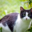

Top 3 Predictions: ['bird: 33.3%', 'dog: 18.5%', 'cat: 13.7%']


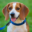

Top 3 Predictions: ['dog: 28.1%', 'cat: 22.6%', 'bird: 15.9%']


In [18]:
from corenet.options.opts import get_training_arguments
from corenet.modeling import get_model
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, PILToTensor, CenterCrop
from torchvision.transforms import ToPILImage
from corenet.data.datasets.classification.playground_dataset import Cifar10

config_file = "projects/playground_cifar10/classification/cifar10.yaml"
pretrained_weights = "results/run_1/checkpoint_best.pt"

opts = get_training_arguments(
    args=[
        "--common.config-file",
        config_file,
        "--model.classification.pretrained",
        pretrained_weights,
    ]
)

# Load the model
model = get_model(opts)
model.eval()

for image_path in ["assets/cat.jpeg", "assets/dog.jpeg"]:
    image = Image.open(image_path).convert("RGB")
    img_transforms = Compose([CenterCrop(600), Resize(size=(32, 32)), PILToTensor()])

    # Transform the image, normalize between 0 and 1
    input_tensor = img_transforms(image)

    # Show the transformed image
    ToPILImage()(input_tensor).show()

    input_tensor = input_tensor.to(torch.float).div(255.0)

    # add dummy batch dimension
    input_tensor = input_tensor[None, ...]

    with torch.no_grad():
        logits = model(input_tensor)[0]
        probs = torch.softmax(logits, dim=-1)
        predictions = sorted(zip(probs.tolist(), Cifar10.CLASS_NAMES), reverse=True)
        print(
            "Top 3 Predictions:",
            [f"{cls}: {prob:.1%}" for prob, cls in predictions[:3]],
        )